In [160]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path

sys.path.append(os.path.abspath(os.path.join('../src')))
from varying_drift_diffusion import *
from motion_simulation import *

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
# sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

In [161]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [146]:
# simulation
N_SIM = 1000
N_OBS = 100

# bayesflow
PARAM_NAMES = ["a", "ndt", "bias", "kappa"]
N_PARAMS = len(PARAM_NAMES)
N_EPOCHS = 30
ITER_PER_EPOCH = 1000
BATCH_SIZE = 32
N_SAMPLES = 2000

## Simulator Test

In [148]:
n_obs = 100
a     = 1.0
ndt   = 0.2
bias  = 0.5
kappa = 0.1
theta = np.array([a, ndt, bias, kappa])

motion_profiles, condition = motion_experiment(n_obs, n_unique_motions=5, motion_dur=2)
rt, resp = var_dm_simulator(theta, n_obs, motion_profiles)


In [151]:
%time
p_, x_ = var_dm_batch_simulator(32, 100)
x_.shape

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


(32, 100, 12)

## Bayes Flow

In [9]:
# default summary network
summary_net = InvariantNetwork()

2021-11-30 16:12:18.140741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# invertable inference network
meta_dict={
    'n_coupling_layers': 5,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'permute': True,
    'use_act_norm': True,
    'n_params': N_PARAMS
}

inference_net = InvertibleNetwork(meta_dict)

In [11]:
# Connect summary and inference network
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Learning-rate decay
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, 1000, 0.99, staircase=True
)

trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=var_dm_batch_simulator,
    learning_rate=learning_rate,
    # checkpoint_path='../src/checkpoints/time_var_dm',
    checkpoint_path='../src/selected_checkpoints/time_var_dm',
    clip_value=3,
    max_to_keep=5
)

Networks loaded from ../src/selected_checkpoints/time_var_dm/ckpt-70


In [12]:
%%time
# online training
# losses = trainer.train_online(N_EPOCHS, ITER_PER_EPOCH, BATCH_SIZE, n_obs=N_OBS)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


## Parameter Recovery

In [13]:
# Simulate and amortized inference
p_, x_ = var_dm_batch_simulator(n_sim=N_SIM,n_obs=N_OBS)
samples = amortizer.sample(x_, n_samples=N_SAMPLES)
param_means = samples.mean(axis=1)

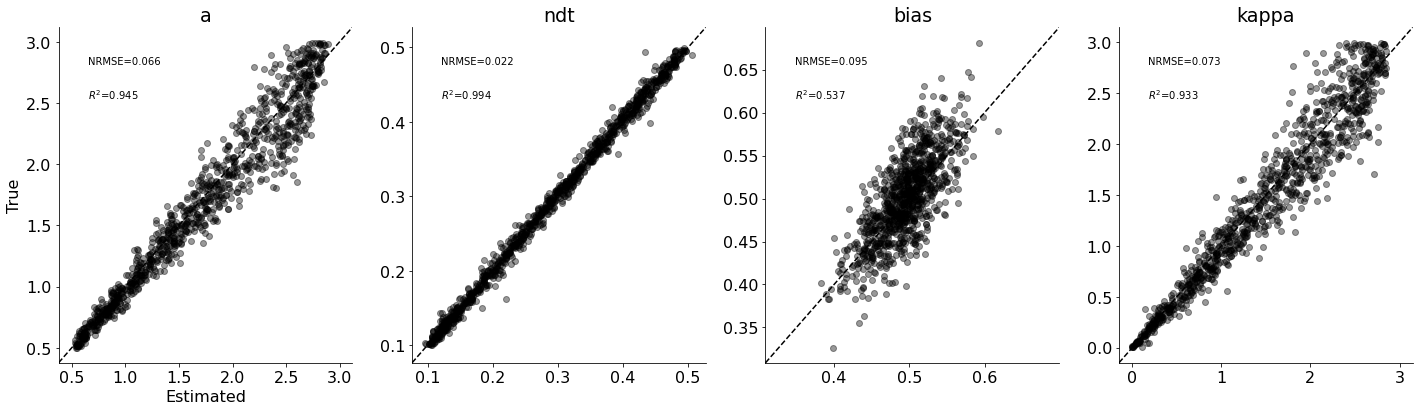

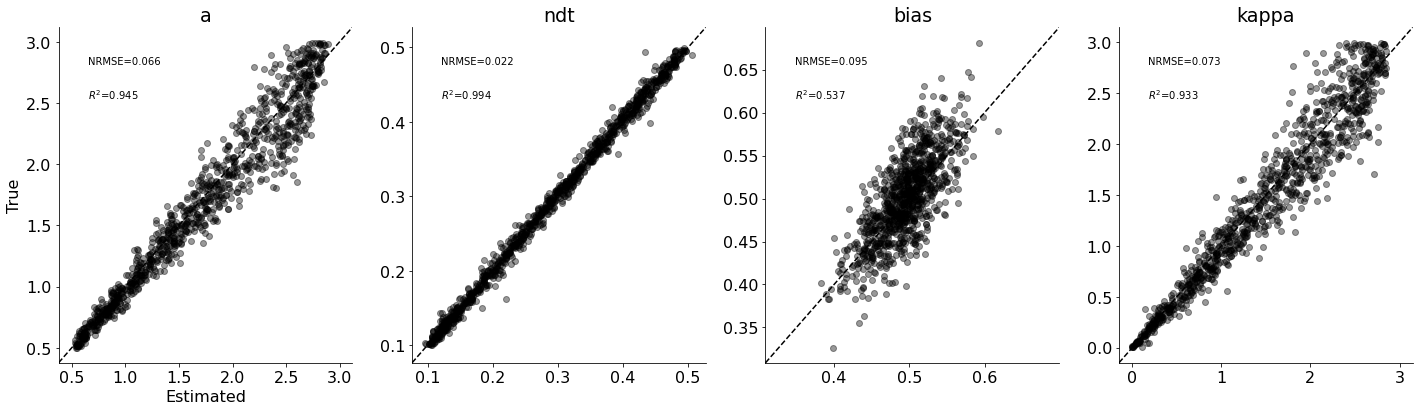

In [14]:
# Recovery plot
true_vs_estimated(theta_true=p_, theta_est=param_means,
                  param_names=PARAM_NAMES, dpi=300, figsize=(20,6),font_size=16)

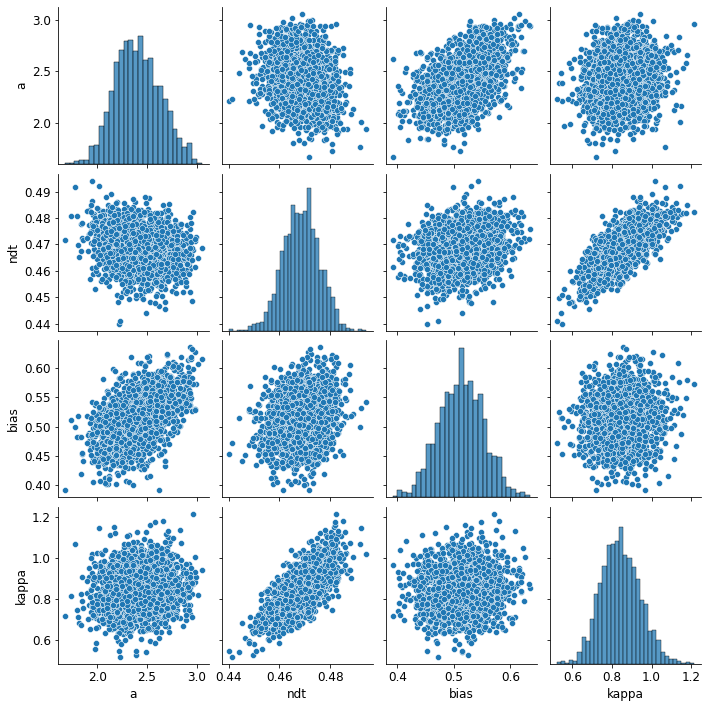

In [22]:
sns.pairplot(pd.DataFrame(samples[0], columns=PARAM_NAMES))

## Simulation Based Calibration

In [15]:
# Simulate
n_sbc = 5000
n_post_samples_sbc = 250
params, sim_data = var_dm_batch_simulator(n_sbc, N_OBS)

In [16]:
# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

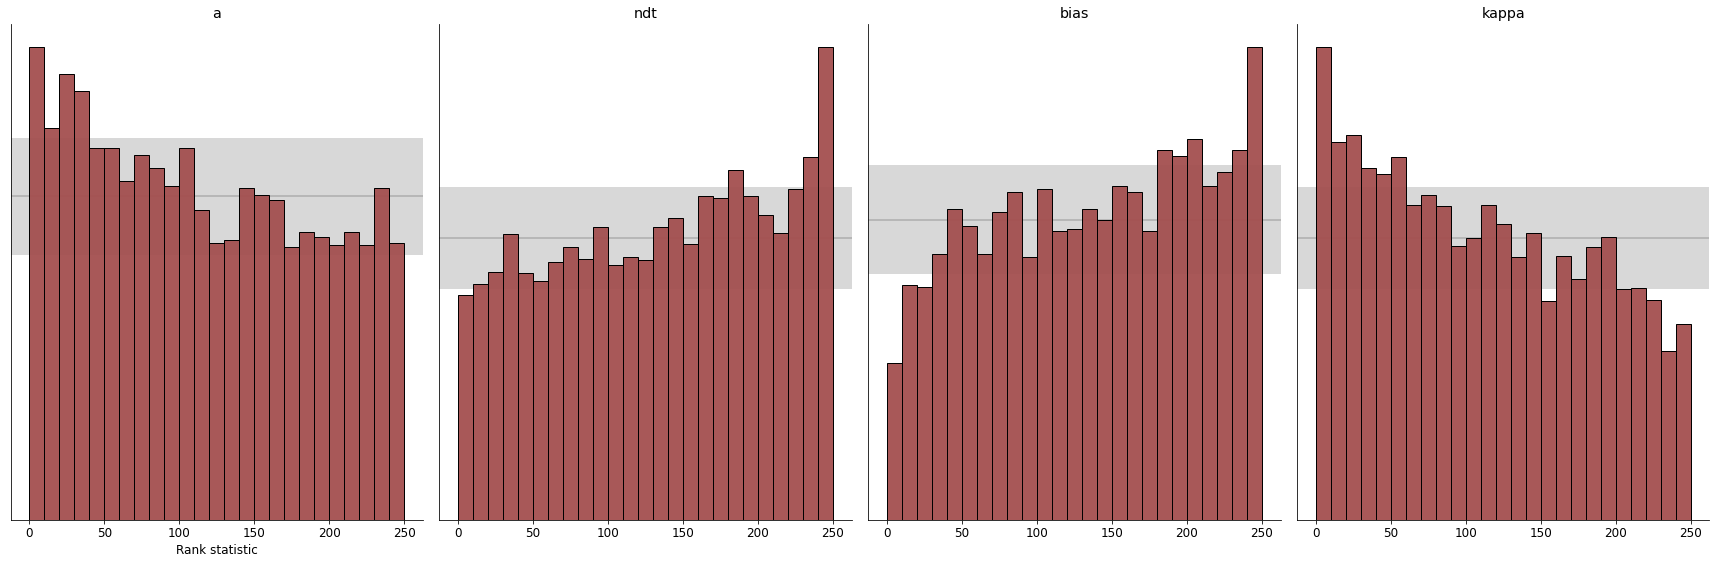

In [17]:
# Rank-plot
f = plot_sbc(param_samples, params, param_names=PARAM_NAMES, figsize=(24, 8))

## Bayesian Eye Chart

In [23]:
# Simulation
true_params, sim_data = var_dm_batch_simulator(N_SIM, N_OBS)

# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, N_SAMPLES)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

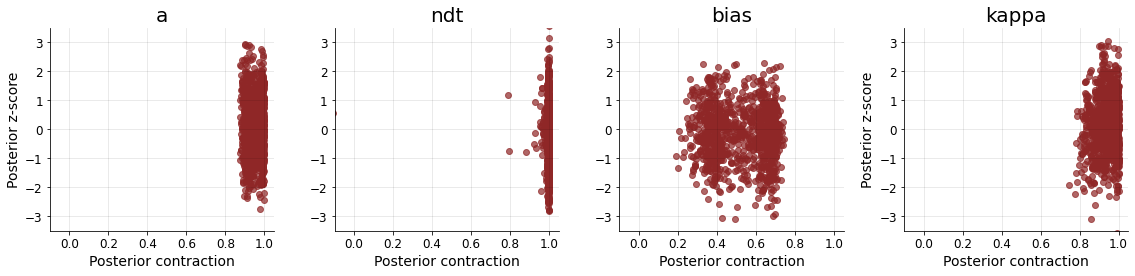

In [27]:
### Posterior z-score
# Compute posterior means and stds
post_means = param_samples.mean(1)
post_stds = param_samples.std(1)
post_vars = param_samples.var(1)

# Compute posterior z score
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.5, 0.1, 0.0) # lower bound of uniform prior
prior_b = (3.0, 0.5, 3.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
prior_vars = np.concatenate((prior_vars[0:2], np.array([0.0025]), prior_vars[2:]))
post_cont = 1 - post_vars / prior_vars

# Plotting time
f, axarr = plt.subplots(1, 4, figsize=(16, 4))
for i, (p, ax) in enumerate(zip(PARAM_NAMES, axarr.flat)):


    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

In [136]:
# empirical data preparation
directory = str(Path().absolute())
path = str(Path(directory).parents[1]) + '/evidence-accumulators/data/single_sub_data.csv'
# data = np.loadtxt(open(path, 'rb'), delimiter=",", skiprows=1)
data = pd.read_csv(path)

In [139]:
idx = np.where((data["condition"] == 1) & (data["instruction"] == 1))
data = data.loc[idx]
data.head()

,id,condition,instruction,motion_duration,motion,resp,rt
0,1,1,1,1,0.725,0,1.469
1,1,1,1,1,0.625,0,1.599
2,1,1,1,1,-0.575,1,3.674
3,1,1,1,1,-0.525,1,2.052
4,1,1,1,1,0.725,0,1.714


In [162]:
amplitude = data["motion"]
frequency = data["motion_duration"][0]
motion_dur = data["motion_duration"][0]

motion_set, condition = motion_experiment_manual(motion_dur, amplitude, frequency)
